## Run this script on a GPU

In [1]:
import jax
print("jax version:", jax.__version__)
print("Devices:", jax.devices())

jax version: 0.4.23
Devices: [cuda(id=0)]


In [1]:
import pandas as pd

df = pd.read_csv("data/df_indi_works.csv", index_col=0)
#df = pd.read_csv("data/df_indi_works_clean_gdp.csv", index_col=0)

print(len(df))

regions = pd.read_csv('data/ENS - Cultural Index - Countries Databases - region_level.csv')
regions = regions[regions['level'] == 2]
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]
df["century"] = df["decade"].round(-2)
df.head(n=10)
max(df.decade)

570881


1880

,individual_wikidata_id,decade,individual_name,score,region_code,region_name,count_works,century
2,Q202809,1840,Frederick Coombs,12,re_united_kingdom,United Kingdom,0.0,1800
4,Q4350107,1820,Vassili Perevoštšikov,4,re_eastern_europe,Eastern Europe,0.0,1800
5,Q4350107,1820,Vassili Perevoštšikov,4,re_slav_world,Slav world,0.0,1800
8,Q1028749,1720,Christian Friedrich Zincke,37,re_united_kingdom,United Kingdom,22.0,1700
12,Q2822993,1140,Achard of Saint-Victor,46,re_united_kingdom,United Kingdom,0.0,1100
...,...,...,...,...,...,...,...,...
570870,Q5549197,1870,Michael Anagnos,14,re_eastern_europe,Eastern Europe,0.0,1900
570874,Q55191347,1770,Jean-Baptiste Daubanton,1,re_france,France,0.0,1800
570876,Q43136014,1880,Alexandre Nicolaievich Roussoff,12,re_eastern_europe,Eastern Europe,0.0,1900
570877,Q43136014,1880,Alexandre Nicolaievich Roussoff,12,re_slav_world,Slav world,0.0,1900


In [3]:
len(df)

179246

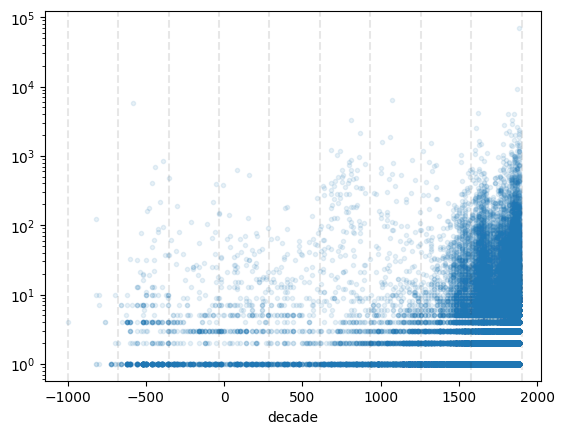

In [4]:
import matplotlib.pyplot as plt
import numpy as np

num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)


fig, ax = plt.subplots()
(df.groupby(["decade", "individual_wikidata_id"])["count_works"].sum() + 1).droplevel(
    level="individual_wikidata_id").plot(style=".", alpha=0.1, logy=True, ax=ax)

for knot in knots:
    ax.axvline(knot, color="0.1", alpha=0.1, ls="--")

In [5]:
df['count'] = df['count_works']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})] # Not more ?
df_m['y'] = df_m['count'].map({0: 0, 1: 0, 2: 1})
df_m.sample(10)

print(len(df_m))

158156


Plot the global probability of observing a producer twice in the dataset, i.e. $p(n_{\text{obs}} = 2)$:

## Varying Splines Analysis on Regions

In [51]:
import bambi as bmb
import arviz as az

iknots = knots[1:-1]

print(iknots)
"""
sample = df_m

df_m[['decade', 'y']].sample(10)

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "bs(decade, knots = iknots, intercept = True)|region_name": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.5))
}

m_splines_vs = bmb.Model(
    'y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vs"""

#  Global Spline Analysis with Varying Intercepts for Region

sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

m_splines_vi = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vi

[-677.77777778 -355.55555556  -33.33333333  288.88888889  611.11111111
  933.33333333 1255.55555556 1577.77777778]


       Formula: y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)
        Family: bernoulli
          Link: p = logit
  Observations: 158156
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots=iknots, intercept=True) ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.0))

In [ ]:
p_splines_vs = m_splines_vi.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro')  # important to run faster and sample more efficiently




In [53]:
az.summary(p_splines_vs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.683,1.437,-5.306,-0.027,0.054,0.039,699.0,872.0,1.0
"bs(decade, knots=iknots, intercept=True)[0]",-2.328,3.304,-8.547,3.426,0.075,0.058,2054.0,2309.0,1.0
"bs(decade, knots=iknots, intercept=True)[1]",2.102,1.943,-1.463,5.800,0.057,0.040,1157.0,1778.0,1.0
"bs(decade, knots=iknots, intercept=True)[2]",0.224,1.565,-2.725,3.072,0.056,0.040,784.0,1223.0,1.0
"bs(decade, knots=iknots, intercept=True)[3]",0.450,1.471,-2.130,3.275,0.054,0.038,752.0,1058.0,1.0
"bs(decade, knots=iknots, intercept=True)[4]",-0.272,1.488,-3.026,2.512,0.055,0.039,723.0,1142.0,1.0
"bs(decade, knots=iknots, intercept=True)[5]",1.223,1.470,-1.512,3.897,0.054,0.038,734.0,1012.0,1.0
"bs(decade, knots=iknots, intercept=True)[6]",-0.084,1.477,-2.837,2.680,0.054,0.038,748.0,922.0,1.0
"bs(decade, knots=iknots, intercept=True)[7]",0.010,1.463,-2.719,2.687,0.054,0.039,722.0,1005.0,1.0
"bs(decade, knots=iknots, intercept=True)[8]",0.220,1.441,-2.388,2.903,0.054,0.038,716.0,962.0,1.0


Plot the regional probability of observing a producer twice in the dataset over time, i.e. 𝑝(𝑛obs=2):

In [54]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

def plot_predictions(data, idata, model, region=None, ax=None, plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    if region is not None:
        data = data[data["region_name"] == region]
        new_data["region_name"] = [region] * 500
    new_data["decade"] = np.linspace(data["decade"].min(), data["decade"].max(), num=500)
    new_data = pd.DataFrame(new_data)

    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    y_hat = posterior_stacked["y_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

    # Plot credibility bands
    ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="p(n_obs=2)")

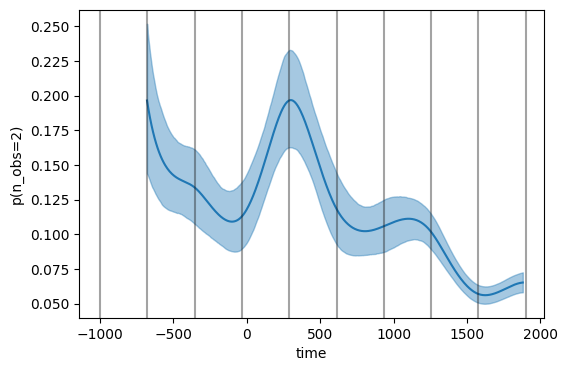

In [55]:
region = 'Chinese world'
fig, ax = plt.subplots(figsize=(6, 4))  
plot_predictions(
        sample, p_splines_vs, m_splines_vi, region, ax=ax)

fig.savefig('results/china_spline.png', dpi=300)

Text(0.5, 0.01, 'time')

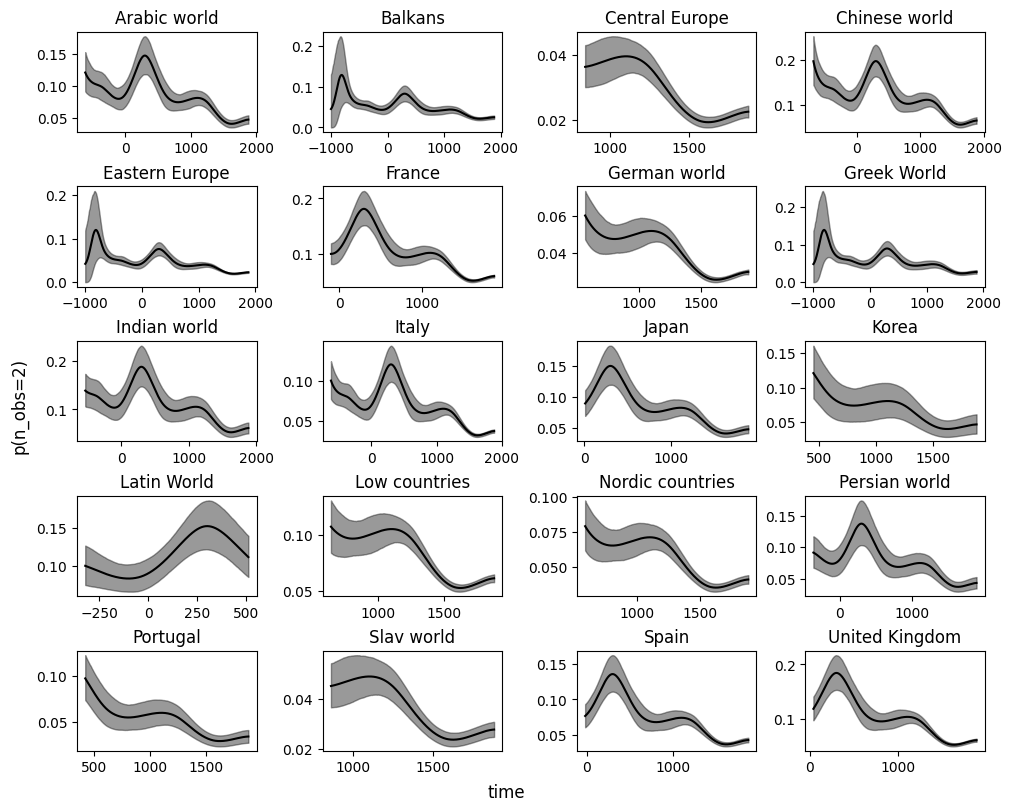

In [56]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

for i, region in enumerate(sorted(df_m["region_name"].unique())):
    plot_predictions(
        sample, p_splines_vs, m_splines_vi, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")

fig.supylabel('p(n_obs=2)')
fig.supxlabel('time')

In [57]:
def plot_estimations(data, obs_data, idata, model, region=None, ax=None, logy=False, 
                     plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    data = data[data["region_name"] == region]
    obs_data = obs_data[obs_data["region_name"] == region]   
    
    new_data["decade"] = data["decade"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)
    
    new_data = pd.DataFrame(new_data)
    
    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    decades = np.array(sorted(data["decade"].unique()))
    
    N_est = np.zeros((len(decades), f0.shape[1]))
    unseen = np.zeros((len(decades), f0.shape[1]))
    
    for i, decade in enumerate(decades):
        n_obs_di = data.loc[data["decade"] == decade, "individual_wikidata_id"].nunique()
        mask = (new_data["decade"] == decade).astype(int).values[:, None]
        f0_di = (f0 * mask).sum(0)
        S_di = n_obs_di + f0_di
        N_est[i] = S_di
        unseen[i] = f0_di

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(N_est, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=region)
    
    df[df["region_name"] == region].groupby("decade")["individual_wikidata_id"].count().plot(
        ax=ax, ls="--", color="red")
    
    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")
    
    return unseen, N_est, hdi_data, decades

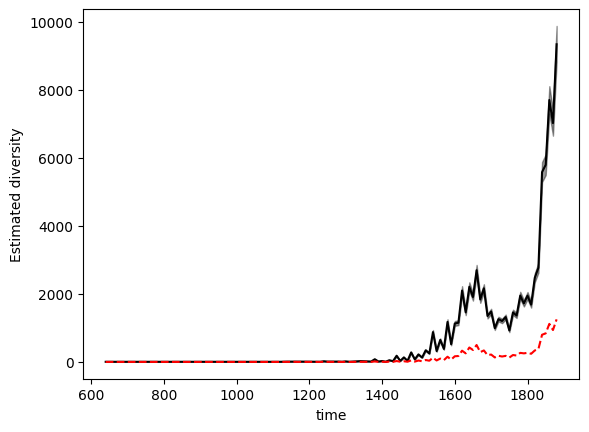

In [58]:
plot_estimations(
    sample, df, p_splines_vs, m_splines_vi, "Low countries", color="k", plot_knot_lines=False, logy =False);

Text(0.5, 0.01, 'time')

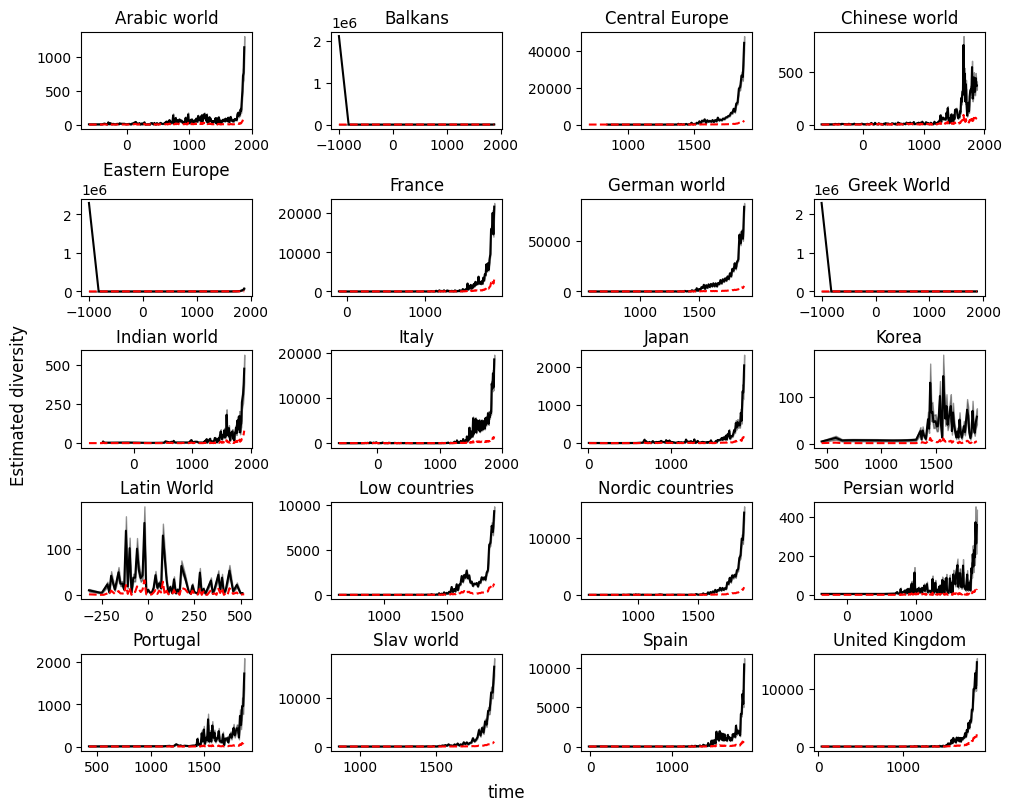

In [60]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

results = {}
for i, region in enumerate(sorted(df_m["region_name"].unique())):
    f0, N_est, hdi, decades = plot_estimations(
        sample, df, p_splines_vs, m_splines_vi, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")
    results[region] = f0, N_est, hdi, decades

fig.supylabel('Estimated diversity')
fig.supxlabel('time')


In [61]:
fig.savefig('results/estimated_diversity_per_region.png', dpi=300)

In [32]:
def plot_trend(decades, N_est, hdi_data, color="C0", label=None, ax=None, logy=False, figsize=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=label)

    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")

    return ax

(-500.0, 1900.0)

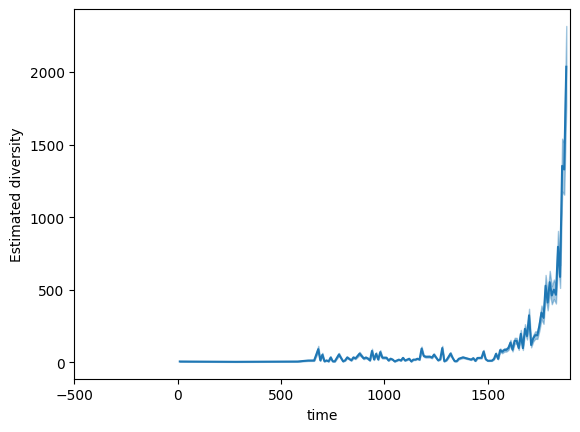

In [62]:
region = 'Japan'

f0, N_est, hdi, decades = results[region]

ax = plot_trend(decades, N_est, hdi, label=region)
ax.set_xlim(-500, 1900)

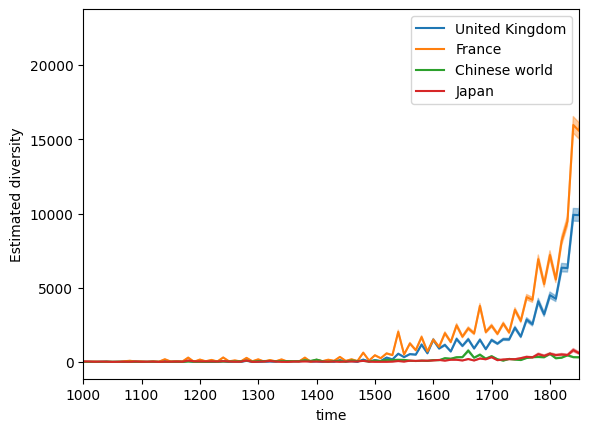

In [63]:
regions = "United Kingdom", "France", "Chinese world", "Japan"

fig, ax = plt.subplots()
for i, region in enumerate(regions):
    f0, N_est, hdi, decades = results[region]
    ax = plot_trend(decades, N_est, hdi, color=f"C{i}", logy=False, label=region, ax=ax)
ax.set_xlim(1000, 1850)
ax.legend()

In [150]:
import pickle

with open("regression-dump.pickle", "wb") as out:
    pickle.dump(results, out)

In [64]:
table = []
for region in results:
    _, N_est, hdi, decades = results[region]
    N_est = N_est.mean(1)
    li, ui = hdi[0], hdi[1]
    print(N_est.shape, li.shape, ui.shape, decades.shape)
    table.append(pd.DataFrame({
        "N_est": N_est,
        "lower": li,
        "upper": ui,
        "decade": decades,
        "region": [region] * N_est.shape[0]
    }))
table = pd.concat(table)
table.head()

table.to_csv("results/estimations_charles.csv", index=False)
#table.to_csv("results/estimations.csv", index=False)
#table.to_csv("results/estimations_clean_gdp.csv", index=False)

(186,) (186,) (186,) (186,)
(137,) (137,) (137,) (137,)
(71,) (71,) (71,) (71,)
(189,) (189,) (189,) (189,)
(154,) (154,) (154,) (154,)
(113,) (113,) (113,) (113,)
(103,) (103,) (103,) (103,)
(199,) (199,) (199,) (199,)
(101,) (101,) (101,) (101,)
(166,) (166,) (166,) (166,)
(116,) (116,) (116,) (116,)
(70,) (70,) (70,) (70,)
(64,) (64,) (64,) (64,)
(71,) (71,) (71,) (71,)
(84,) (84,) (84,) (84,)
(109,) (109,) (109,) (109,)
(65,) (65,) (65,) (65,)
(57,) (57,) (57,) (57,)
(97,) (97,) (97,) (97,)
(94,) (94,) (94,) (94,)


,N_est,lower,upper,decade,region
0,4.386424,3.353913,5.531837,-610,Arabic world
1,4.906361,3.892610,6.024399,-520,Arabic world
2,5.188855,4.135945,6.329057,-400,Arabic world
3,15.920481,12.577407,19.575755,-360,Arabic world
4,5.431743,4.280787,6.679775,-330,Arabic world


<Axes: xlabel='decade'>

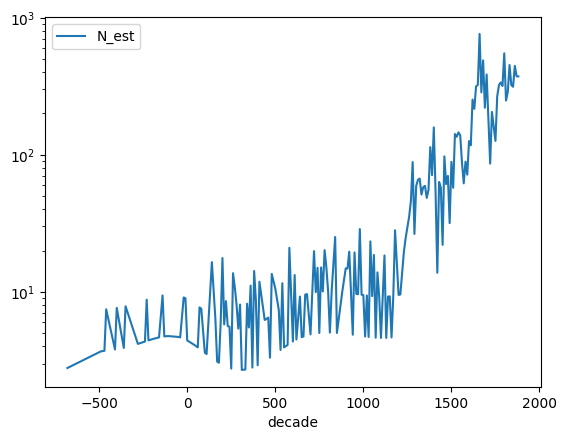

In [66]:
test = table[table['region']=='Chinese world']
test.plot(x='decade', y ='N_est', logy=True)